# Study 2 – Descriptive Dataset Analysis
This notebook characterises the dataset used in this thesis at patient, recording 
and seizure level. It ensures transparency in the structure, quality and distribution 
of the available ECG + annotation data prior to further SQI/HRV analysis.

In [1]:
import sys
import jinja2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from hrv_epatch.plots.plotstyle import set_project_style, palette
from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from hrv_epatch.dataset.summary import (
    build_patient_summary,
    compute_within_recording_isi,
    compute_dataset_overview,
    summarise_isi,
)

set_project_style()
PROJECT_ROOT, SRC_ROOT

# from hrv_epatch.dataset.loader import iter_recordings
# from hrv_epatch.dataset.naming import parse_recording_key
# from hrv_epatch.dataset.annotations import load_annotations   # for debugging if needed
# from hrv_epatch.dataset.seizures import SeizureEvent, build_seizure_events_from_df
# from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
# from src.hrv_epatch.plots.plotstyle import set_project_style, palette


(WindowsPath('c:/Users/kvjkv/Git1/Epilepsy_MasterThesis'),
 WindowsPath('c:/Users/kvjkv/Git1/Epilepsy_MasterThesis/src'))

## 1. Load dataset (TDMS + annotations from 01_build)

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
df_rec.head(), df_evt.head()


# Create copies to avoid unintentional modifications
df_rec_sum = df_rec.copy()
df_evt_sum = df_evt.copy()

## 2 Dataset-overview (Key metrics)

In [3]:
df_overview = compute_dataset_overview(df_rec, df_evt)
df_overview

print(df_overview.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Patients & 43.00 \\
Enrollments & 50.00 \\
Recordings & 72.00 \\
Total hours & 3264.03 \\
Total seizures & 149.00 \\
Median rec. duration (h) & 45.55 \\
IQR rec. duration (h) & 9.04 \\
\bottomrule
\end{tabular}



## 3 Gantt-figur

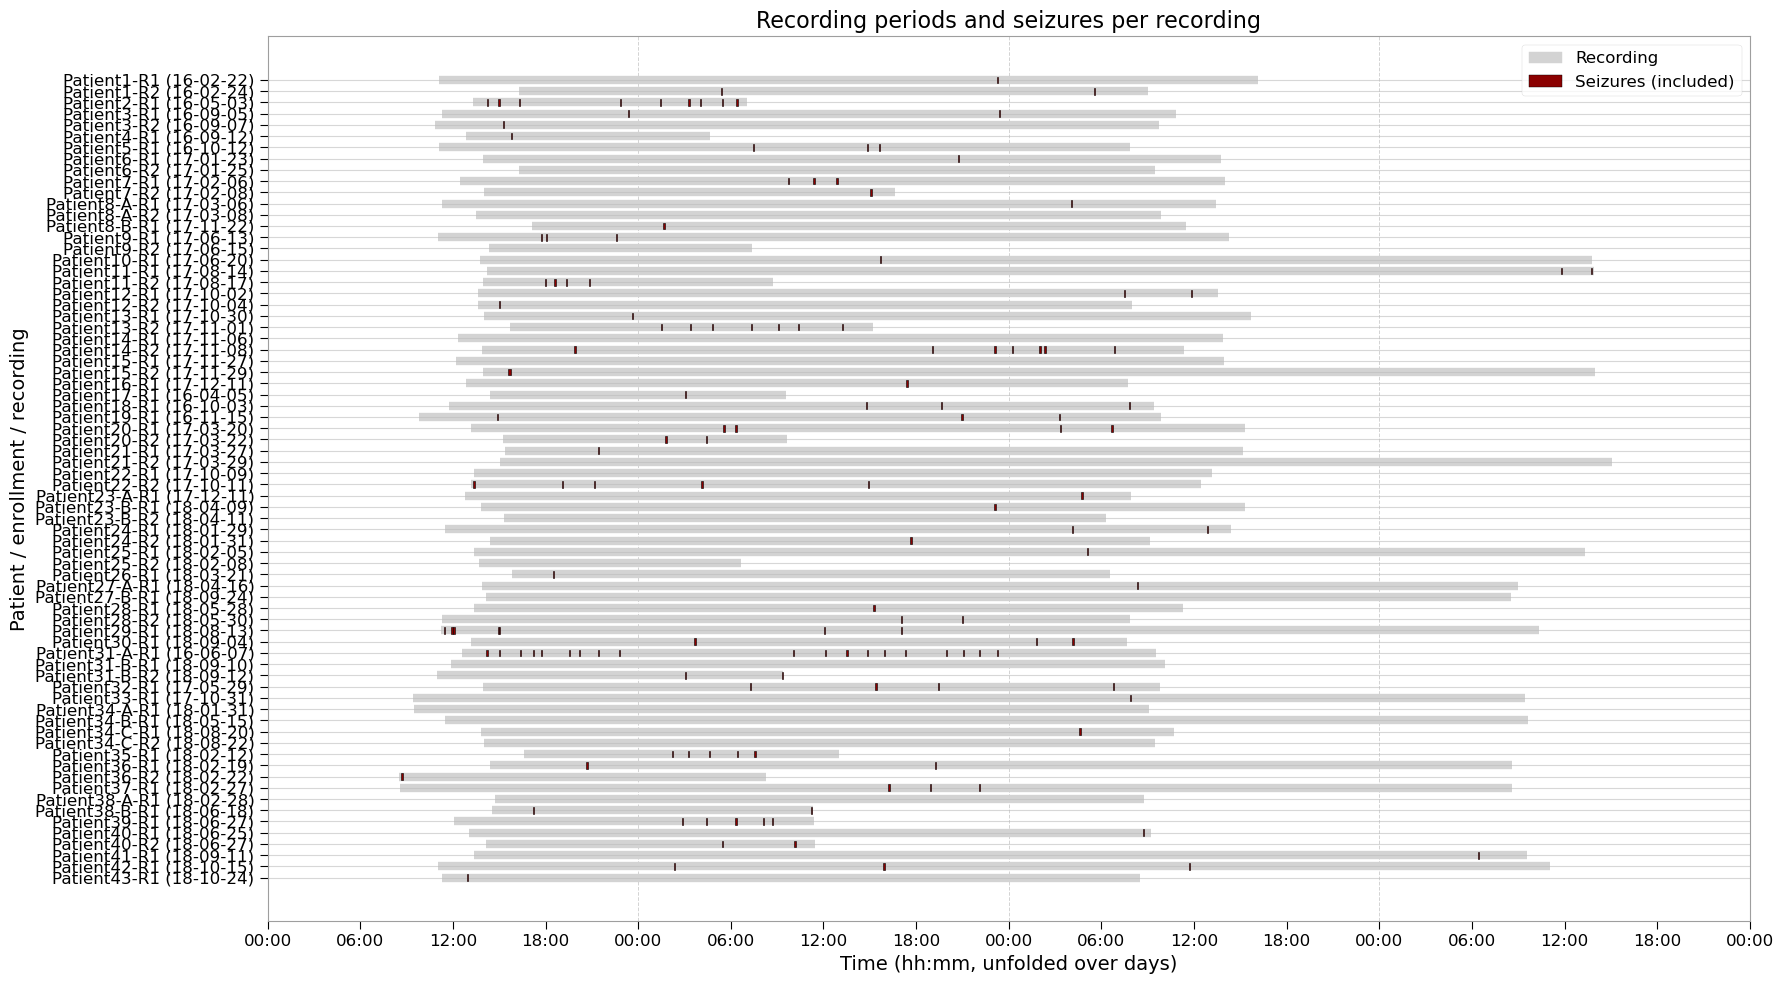

In [4]:
fig, ax = plot_gantt_from_index(df_rec, df_evt, max_hours=96)
fig.savefig(OUT_DIR / "study2_gantt_overview.png", dpi=300, bbox_inches="tight")

## 4 Patient-level summary
Total hours, number of recordings, number of seizures etc.

In [5]:
df_patient_summary = build_patient_summary(df_rec, df_evt)
df_patient_summary

print(df_patient_summary.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rlrrrr}
\toprule
Patient & Enrollment & Recordings & Total_hours & Total_seizures & Hours_per_seizure \\
\midrule
1 & - & 2 & 93.84 & 3.00 & 31.28 \\
2 & - & 1 & 17.75 & 9.00 & 1.97 \\
3 & - & 2 & 94.40 & 3.00 & 31.47 \\
4 & - & 1 & 15.81 & 1.00 & 15.81 \\
5 & - & 1 & 44.74 & 3.00 & 14.91 \\
6 & - & 2 & 89.01 & 1.00 & 89.01 \\
7 & - & 2 & 76.14 & 4.00 & 19.04 \\
8 & a & 2 & 94.57 & 1.00 & 94.57 \\
8 & b & 1 & 42.34 & 1.00 & 42.34 \\
9 & - & 2 & 68.25 & 3.00 & 22.75 \\
10 & - & 1 & 72.00 & 1.00 & 72.00 \\
11 & - & 2 & 90.50 & 6.00 & 15.08 \\
12 & - & 2 & 90.37 & 3.00 & 30.12 \\
13 & - & 2 & 73.17 & 8.00 & 9.15 \\
14 & - & 2 & 94.99 & 7.00 & 13.57 \\
15 & - & 2 & 121.77 & 1.00 & 121.77 \\
16 & - & 1 & 42.85 & 1.00 & 42.85 \\
17 & - & 1 & 19.21 & 1.00 & 19.21 \\
18 & - & 1 & 45.65 & 3.00 & 15.22 \\
19 & - & 1 & 48.02 & 3.00 & 16.01 \\
20 & - & 2 & 68.54 & 6.00 & 11.42 \\
21 & - & 2 & 119.79 & 1.00 & 119.79 \\
22 & - & 2 & 95.02 & 5.00 & 19.00 \\
23 & a & 1 & 43.14 & 1.00 &

# 4. A Total recording time for each patient/enrollment

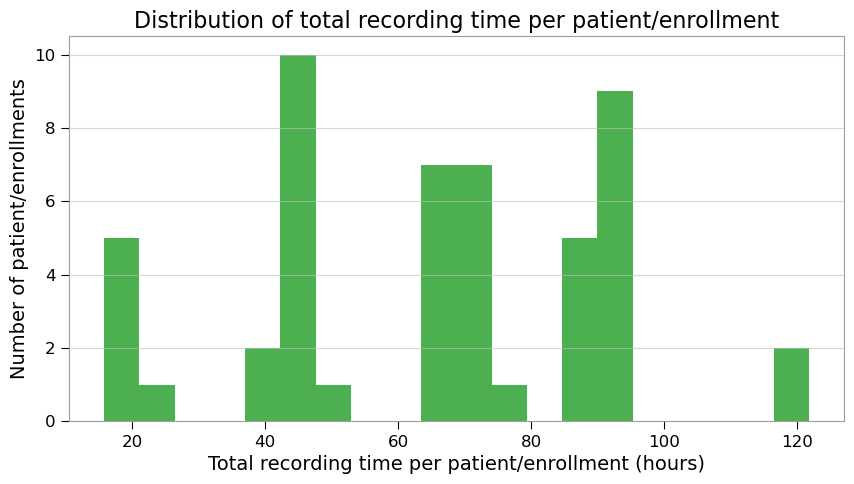

In [6]:
total_hours_pat = df_patient_summary["Total_hours"]

plt.figure(figsize=(10, 5))
plt.hist(total_hours_pat, bins=20, color=palette["primary"])
plt.xlabel("Total recording time per patient/enrollment (hours)")
plt.ylabel("Number of patient/enrollments")
plt.title("Distribution of total recording time per patient/enrollment")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 5 Recording duration distribution

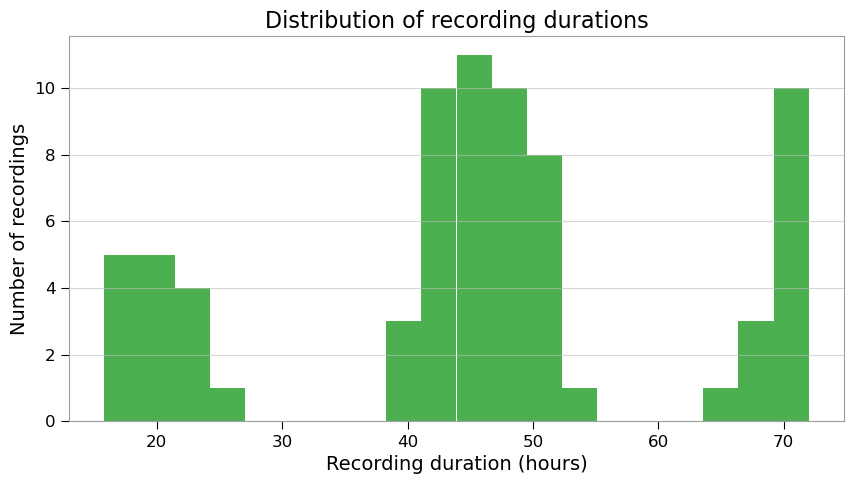

In [7]:
dur_hours = df_rec["rec_duration_s"] / 3600.0

plt.figure(figsize=(10, 5))
plt.hist(dur_hours, bins=20, color=palette["primary"])
plt.xlabel("Recording duration (hours)")
plt.ylabel("Number of recordings")
plt.title("Distribution of recording durations")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

## 6 Seizures pr. recording & pr. patient

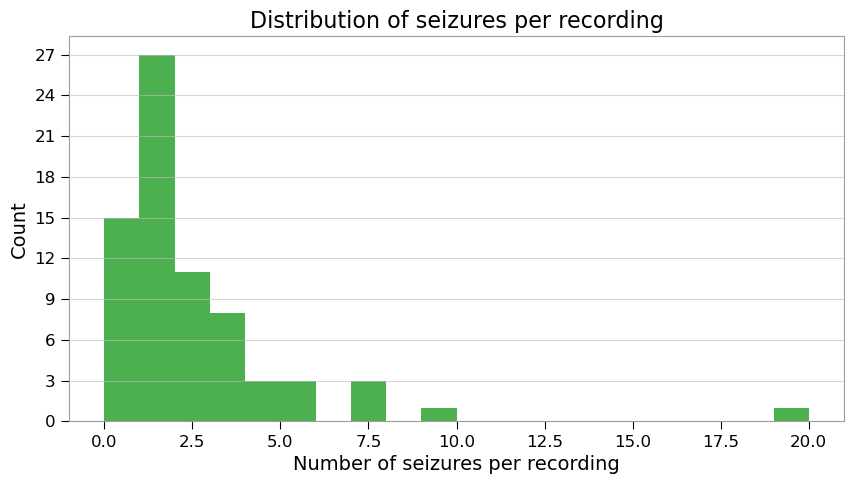

In [8]:
# Seizures per recording
seiz_per_rec = (
    df_evt
    .groupby("recording_uid")["seizure_id"]
    .count()
    .reindex(df_rec["recording_uid"], fill_value=0)
)

plt.figure(figsize=(10, 5))
plt.hist(seiz_per_rec, bins=range(0, int(seiz_per_rec.max()) + 2), color=palette["primary"])
plt.xlabel("Number of seizures per recording")
plt.ylabel("Count")
plt.title("Distribution of seizures per recording")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

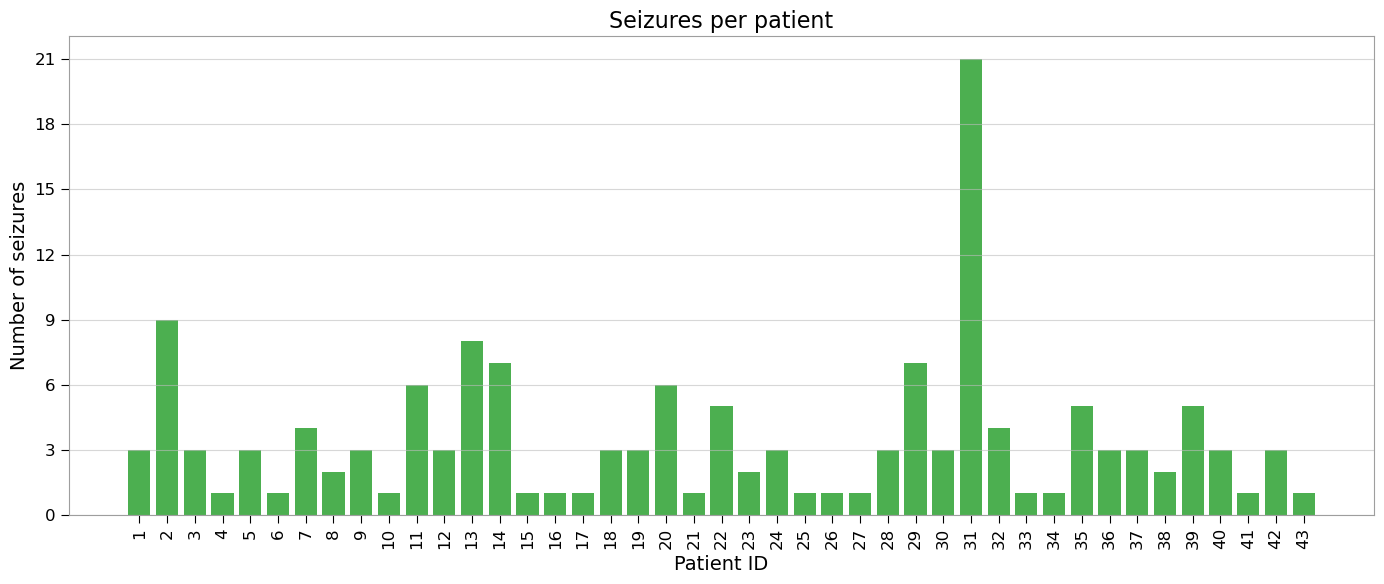

In [9]:
# Seizures per patient
seiz_per_patient = df_evt.groupby("patient_id")["seizure_id"].count()

plt.figure(figsize=(14, 6))
plt.bar(seiz_per_patient.index.astype(str), seiz_per_patient.values, color=palette["primary"])
plt.xlabel("Patient ID")
plt.ylabel("Number of seizures")
plt.title("Seizures per patient")
plt.xticks(rotation=90)

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [10]:
df_evt.columns


Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'seizure_id', 't0', 't1', 'duration_s', 'absolute_start',
       'absolute_end'],
      dtype='object')

## 7 Seizure duration distribution

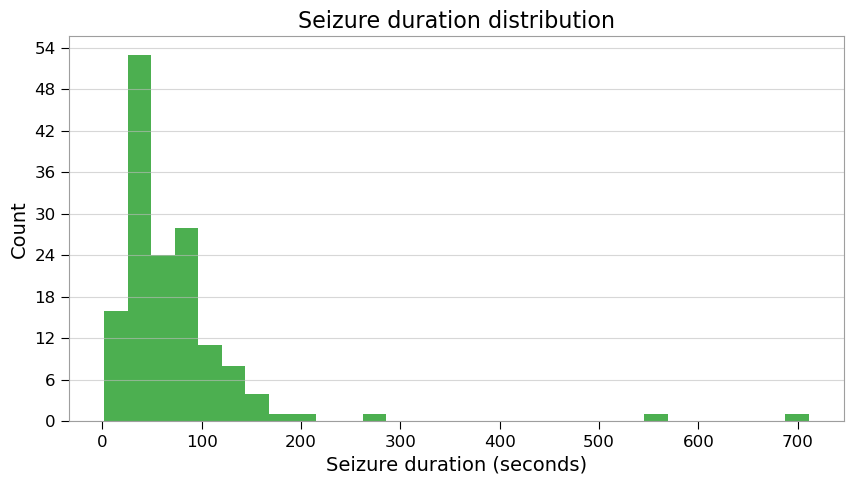

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(df_evt["duration_s"], bins=30, color=palette["primary"])
plt.xlabel("Seizure duration (seconds)")
plt.ylabel("Count")
plt.title("Seizure duration distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=False))

plt.show()


## 8 Time-of-day distribution for seizures

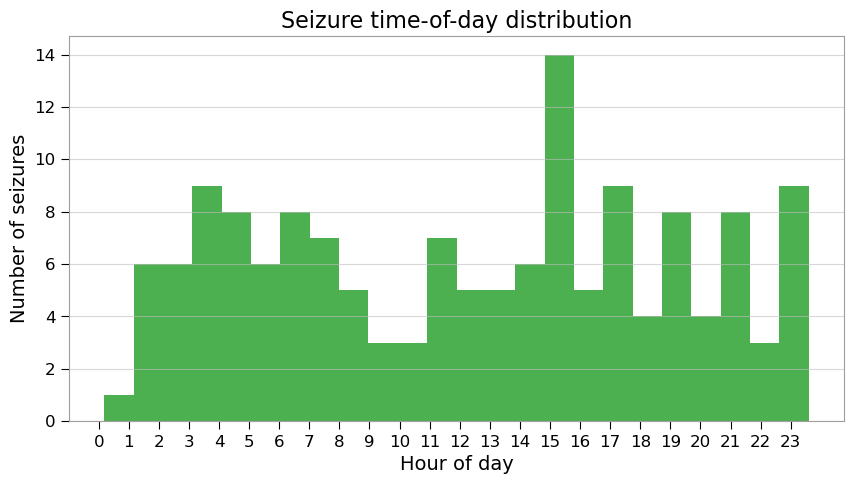

In [12]:
df_evt["hour_of_day"] = (
    df_evt["absolute_start"].dt.hour
    + df_evt["absolute_start"].dt.minute / 60
)

plt.figure(figsize=(10, 5))
plt.hist(df_evt["hour_of_day"], bins=24, color=palette["primary"])
plt.xlabel("Hour of day")
plt.ylabel("Number of seizures")
plt.title("Seizure time-of-day distribution")
plt.xticks(range(0, 24))

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 9 Within-recording ISI + stats

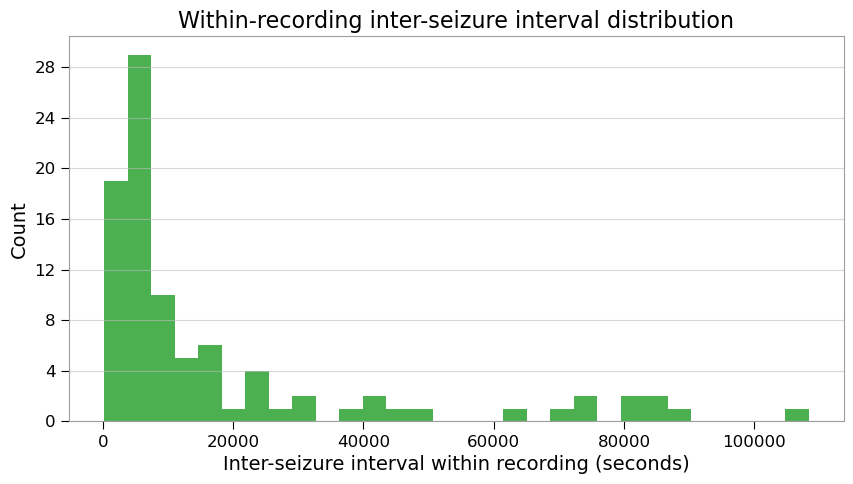

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
n_intervals & 92.00 \\
mean (s) & 18327.05 \\
median (s) & 6808.50 \\
IQR (s) & 14453.00 \\
min (s) & 206.00 \\
max (s) & 108365.00 \\
\bottomrule
\end{tabular}



In [13]:
isi_within = compute_within_recording_isi(df_evt)
len(isi_within)

plt.figure(figsize=(10, 5))
plt.hist(isi_within, bins=30, color=palette["primary"])
plt.xlabel("Inter-seizure interval within recording (seconds)")
plt.ylabel("Count")
plt.title("Within-recording inter-seizure interval distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

df_isi_stats = summarise_isi(isi_within)
df_isi_stats

print(df_isi_stats.to_latex(index=False, float_format="%.2f"))

## 10 Export outputs

In [14]:
STUDY2_OUT = OUT_DIR / "_analysis" / "study2_outputs"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)

df_overview.to_csv(STUDY2_OUT / "dataset_overview.csv", index=False)
df_patient_summary.to_csv(STUDY2_OUT / "patient_summary.csv", index=False)
df_isi_stats.to_csv(STUDY2_OUT / "isi_within_stats.csv", index=False)

print("Saved Study2 outputs to:", STUDY2_OUT)


Saved Study2 outputs to: E:\Speciale - Results\Datastruct\_analysis\study2_outputs
